# LSTM资产收益率预测模型

## 项目概述
本项目使用LSTM深度学习模型对多个资产的长期收益率进行预测。通过构建时序特征和技术指标，训练模型来捕捉资产收益率的动态变化规律。

## 实现步骤
1. 环境配置与依赖导入
2. 数据加载与预处理
3. 特征工程与数据准备
4. 模型构建与训练
5. 模型评估与可视化

## 环境要求
- PyTorch作为Keras后端
- CUDA支持的GPU环境（可选）
- 相关Python库：pandas, numpy, seaborn等

In [1]:
# 配置Keras后端
import os
os.environ["KERAS_BACKEND"] = "torch"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 屏蔽TF日志

In [2]:
# 导入所需库
# 数据处理库
import pandas as pd
import numpy as np

# 数据可视化库
import seaborn as sns
import matplotlib.pyplot as plt

# 深度学习框架
import torch
import keras
from keras.optimizers import Adam
from keras.layers import Conv2D, LSTM, Dense, Reshape, Input, Dropout, BatchNormalization, GlobalAveragePooling2D, TimeDistributed
from keras.callbacks import EarlyStopping, LearningRateScheduler

# 模型评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 估计小样本协方差和相关性
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import MinMaxScaler

In [3]:
# 检查当前Keras后端
print("当前后端:", keras.backend.backend())

当前后端: torch


In [4]:
# 设置matplotlib显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

# 数据预处理与特征工程
1. 加载和清洗资产价格数据
2. 计算对数收益率
3. 计算动态相关系数矩阵序列
4. 准备模型输入数据

In [5]:
# 资产数据加载和预处理
# 从Excel加载三类资产数据：指数、R007和期货
indices = pd.read_excel('资产池行情数据.xlsx', sheet_name='指数数据', header=0, index_col=0, parse_dates=True)
r007 = pd.read_excel('资产池行情数据.xlsx', sheet_name='R007数据', header=0, index_col=0, parse_dates=True)
futures = pd.read_excel('资产池行情数据.xlsx', sheet_name='期货类数据', header=0, index_col=0, parse_dates=True)

# 数据预处理
# 计算R007日化收益率
annual_coef = 1 / 365  # 年化系数
r007 = ((1 + r007['R007'] / 100) ** annual_coef - 1).rename('R007_收益率')

# 移除期货数据中的缺失值
futures.dropna(inplace=True, how='any')

# 内连接所有资产数据
assets = pd.merge(indices, futures, how='inner', left_index=True, right_index=True)

In [6]:
assets.head(10)

,沪深300,中证500,中证1000,大盘价值,小盘成长,恒生指数,中债国债总指数(7-10年)财富指数,南华工业品,标普500,纳斯达克100,布油,十年美债,沪金
2008-01-09,5613.758,5356.48,4884.27,7369.5322,4508.8751,27615.8500,114.2991,2183.721,1409.13,1949.20,77.718375,120.002755,224.74
2008-01-10,5672.154,5382.33,4894.59,7459.3015,4536.6797,27230.8600,114.2213,2165.709,1420.33,1953.64,75.947743,119.320736,217.68
2008-01-11,5699.147,5376.80,4867.47,7507.1734,4531.2963,26867.0098,114.3680,2186.840,1401.02,1912.81,75.000661,119.970278,217.79
2008-01-14,5731.757,5445.10,4946.35,7553.5284,4584.2152,26468.1300,114.3696,2187.415,1416.25,1949.15,76.524228,120.035232,219.28
2008-01-15,5696.450,5487.09,4999.92,7521.8148,4627.1209,25837.7800,114.4016,2167.367,1380.95,1894.09,75.053244,120.652296,223.11
2008-01-16,5505.717,5412.91,4957.38,7254.8242,4567.2833,24450.8500,114.4409,2117.386,1373.20,1872.29,73.962402,120.587342,217.51
2008-01-17,5365.624,5270.96,4849.48,7088.5124,4449.5691,25114.9800,114.4613,2131.402,1333.25,1842.10,73.342605,121.123214,215.50
2008-01-18,5414.468,5317.45,4886.73,7150.8164,4490.2334,25201.8700,114.4688,2113.724,1325.19,1844.09,73.739275,121.253122,213.72
2008-01-21,5145.734,5097.23,4680.89,6792.3277,4307.5553,23818.8600,114.6780,2114.695,1325.19,1844.09,72.317874,121.253122,215.20
2008-01-22,4753.868,4661.83,4292.69,6275.9767,3949.8027,21757.6300,114.7723,2055.807,1310.50,1795.61,73.094686,122.454773,207.58


In [7]:
# 计算对数收益率
log_returns = pd.DataFrame()
for column in assets.columns:
    log_returns[f'{column}_收益率'] = np.log(assets[column] / assets[column].shift(1))

asset_returns = log_returns.dropna()
asset_returns = asset_returns.iloc[:, [0, 5, 6, 7, 9, 10, 11, 12]]

# 将R007收益率与资产收益率数据合并
log_returns.dropna(inplace=True, how='all')
log_returns = pd.merge(log_returns, r007, left_index=True, right_index=True, how='left')
log_returns.ffill(inplace=True)  # 向前填充缺失值

In [8]:
log_returns.head(10)

,沪深300_收益率,中证500_收益率,中证1000_收益率,大盘价值_收益率,小盘成长_收益率,恒生指数_收益率,中债国债总指数(7-10年)财富指数_收益率,南华工业品_收益率,标普500_收益率,纳斯达克100_收益率,布油_收益率,十年美债_收益率,沪金_收益率,R007_收益率
2008-01-10,0.010349,0.004814,0.002111,0.012108,0.006148,-0.014039,-0.000681,-0.008283,0.007917,0.002275,-0.023046,-0.005700,-0.031918,0.000066
2008-01-11,0.004748,-0.001028,-0.005556,0.006397,-0.001187,-0.013452,0.001284,0.009710,-0.013689,-0.021121,-0.012549,0.005429,0.000505,0.000055
2008-01-14,0.005706,0.012623,0.016076,0.006156,0.011611,-0.014958,0.000014,0.000263,0.010812,0.018820,0.020110,0.000541,0.006818,0.000056
2008-01-15,-0.006179,0.007682,0.010772,-0.004207,0.009316,-0.024104,0.000280,-0.009207,-0.025241,-0.028655,-0.019410,0.005128,0.017315,0.000066
2008-01-16,-0.034056,-0.013611,-0.008545,-0.036141,-0.013016,-0.055173,0.000343,-0.023331,-0.005628,-0.011576,-0.014641,-0.000539,-0.025420,0.000069
2008-01-17,-0.025774,-0.026574,-0.022006,-0.023191,-0.026111,0.026800,0.000178,0.006598,-0.029524,-0.016256,-0.008415,0.004434,-0.009284,0.000074
2008-01-18,0.009062,0.008781,0.007652,0.008751,0.009097,0.003454,0.000066,-0.008329,-0.006064,0.001080,0.005394,0.001072,-0.008294,0.000071
2008-01-21,-0.050907,-0.042297,-0.043035,-0.051433,-0.041534,-0.056440,0.001826,0.000459,0.000000,0.000000,-0.019464,0.000000,0.006901,0.000074
2008-01-22,-0.079209,-0.089289,-0.086575,-0.079065,-0.086705,-0.090513,0.000822,-0.028242,-0.011147,-0.026641,0.010684,0.009861,-0.036051,0.000102
2008-01-23,0.045489,0.052285,0.040728,0.050975,0.052682,0.101839,0.005577,0.011515,0.021216,-0.003392,-0.020907,0.003178,0.023849,0.000131


In [9]:
asset_returns.head(10)

,沪深300_收益率,恒生指数_收益率,中债国债总指数(7-10年)财富指数_收益率,南华工业品_收益率,纳斯达克100_收益率,布油_收益率,十年美债_收益率,沪金_收益率
2008-01-10,0.010349,-0.014039,-0.000681,-0.008283,0.002275,-0.023046,-0.005700,-0.031918
2008-01-11,0.004748,-0.013452,0.001284,0.009710,-0.021121,-0.012549,0.005429,0.000505
2008-01-14,0.005706,-0.014958,0.000014,0.000263,0.018820,0.020110,0.000541,0.006818
2008-01-15,-0.006179,-0.024104,0.000280,-0.009207,-0.028655,-0.019410,0.005128,0.017315
2008-01-16,-0.034056,-0.055173,0.000343,-0.023331,-0.011576,-0.014641,-0.000539,-0.025420
2008-01-17,-0.025774,0.026800,0.000178,0.006598,-0.016256,-0.008415,0.004434,-0.009284
2008-01-18,0.009062,0.003454,0.000066,-0.008329,0.001080,0.005394,0.001072,-0.008294
2008-01-21,-0.050907,-0.056440,0.001826,0.000459,0.000000,-0.019464,0.000000,0.006901
2008-01-22,-0.079209,-0.090513,0.000822,-0.028242,-0.026641,0.010684,0.009861,-0.036051
2008-01-23,0.045489,0.101839,0.005577,0.011515,-0.003392,-0.020907,0.003178,0.023849


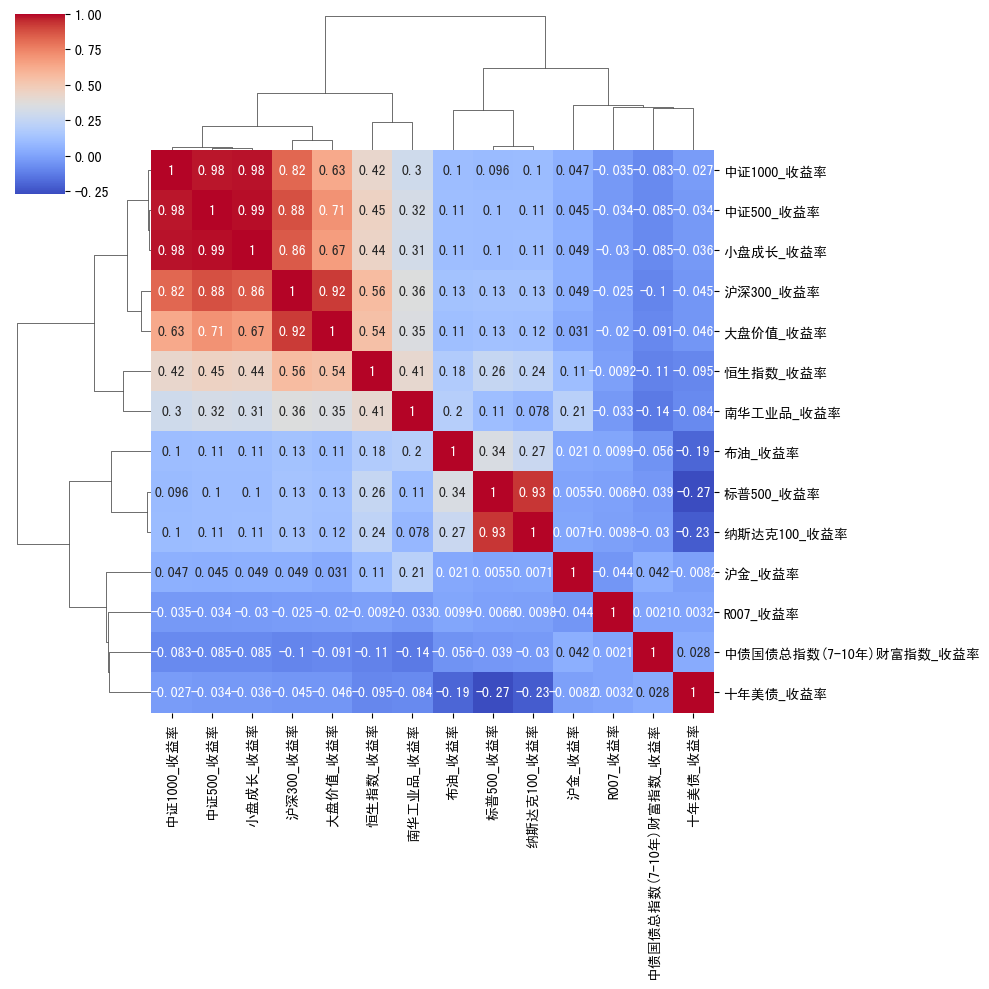

In [10]:
# 计算收益率之间的相关性矩阵并绘制聚类热图
corr_matrix = log_returns.corr()
sns.clustermap(corr_matrix, method='ward', cmap='coolwarm', annot=True)

In [11]:
def rolling_correlation_matrix(df, window=20):
    n = len(df)
    p = df.shape[1]
    corr_series = np.full((n, p, p), np.nan)
    
    for i in range(window, n+1):
        window_data = df.iloc[i-window:i]  # 提取滚动窗口数据
        
        # 使用LedoitWolf估计协方差矩阵
        lw = LedoitWolf().fit(window_data)
        cov_matrix = lw.covariance_
        # cov_matrix = np.array(window_data.cov())
        
        # 将协方差矩阵转换为相关系数矩阵
        std_dev = np.sqrt(np.diag(cov_matrix))
        corr_matrix = cov_matrix / np.outer(std_dev, std_dev)
        
        # 确保对角线为1（数值稳定性）
        np.fill_diagonal(corr_matrix, 1.0)
        
        corr_series[i-1] = corr_matrix  # 存储当前窗口结果
    
    return corr_series

# 计算传统的一年期滚动相关系数矩阵
def rolling_corr_traditional(df, window=252):
    n = len(df)
    p = df.shape[1]
    corr_series_traditional = np.full((n, p, p), np.nan)
    
    for i in range(window, n+1):
        window_data = df.iloc[i-window:i]  # 提取滚动窗口数据
        corr_matrix = window_data.corr().values  # 使用传统的相关系数计算方法
        corr_series_traditional[i-1] = corr_matrix
    
    return corr_series_traditional

In [12]:

# 使用示例
window = 20  # 滚动窗口大小
corr_series = rolling_correlation_matrix(asset_returns, window=window)
print(f"输出形状: {corr_series.shape}")  # (n, 8, 8)
corr_series = corr_series[window-1:]  # 去除NaN值

corr_series_X = rolling_correlation_matrix(log_returns, window=window) 
print(f"输出形状: {corr_series_X.shape}") 
corr_series_X = corr_series_X[window-1:] # (n, 14, 14)

window_traditional = 252  # 传统一年期滚动窗口大小
corr_series_traditional = rolling_corr_traditional(asset_returns, window=window_traditional)
print(f"输出形状: {corr_series_traditional.shape}")
corr_series_traditional = corr_series_traditional[window_traditional-1:]  # 去除NaN值

输出形状: (4218, 8, 8)
输出形状: (4218, 14, 14)
输出形状: (4218, 8, 8)


In [13]:
corr_series[:, 0, 1]

array([0.66207241, 0.68274943, 0.68554273, ..., 0.29826892, 0.30195676,
       0.30025056])

In [14]:
corr_series[0, :, :]

array([[ 1.        ,  0.66207241,  0.01000593,  0.36555513, -0.00848048,
         0.05963981, -0.11544993,  0.19099828],
       [ 0.66207241,  1.        ,  0.05092154,  0.42458358, -0.10215724,
        -0.07608236, -0.00765972,  0.38993041],
       [ 0.01000593,  0.05092154,  1.        ,  0.02695716,  0.04288126,
        -0.02962164,  0.00144834,  0.03846524],
       [ 0.36555513,  0.42458358,  0.02695716,  1.        ,  0.13161684,
         0.06455127, -0.07755767,  0.36486657],
       [-0.00848048, -0.10215724,  0.04288126,  0.13161684,  1.        ,
         0.18267705, -0.15625548,  0.06364433],
       [ 0.05963981, -0.07608236, -0.02962164,  0.06455127,  0.18267705,
         1.        , -0.0889439 ,  0.04778602],
       [-0.11544993, -0.00765972,  0.00144834, -0.07755767, -0.15625548,
        -0.0889439 ,  1.        , -0.02195894],
       [ 0.19099828,  0.38993041,  0.03846524,  0.36486657,  0.06364433,
         0.04778602, -0.02195894,  1.        ]])

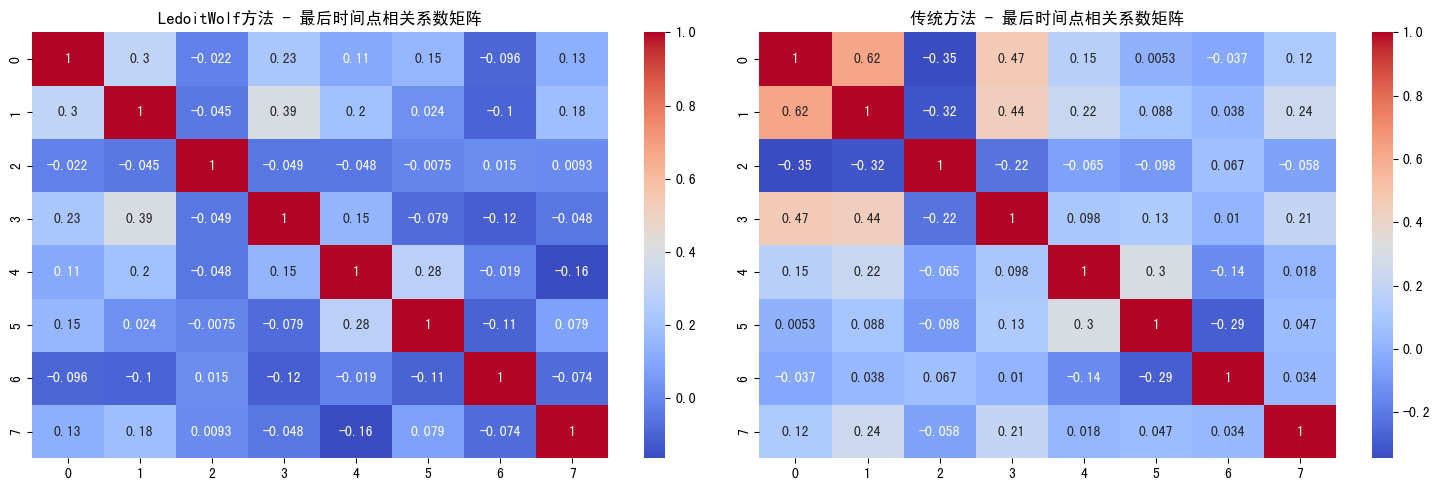

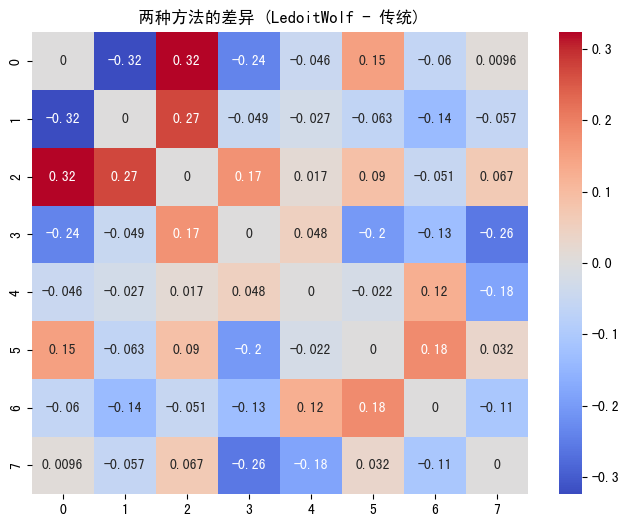


差异的基本统计量：
最大差异: 0.32378772740186884
平均绝对差异: 0.10764877199777056
标准差: 0.14333844131920578


In [15]:
# 比较两种方法在最后一个时间点的相关系数矩阵
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(corr_series[-1], cmap='coolwarm', annot=True)
plt.title("LedoitWolf方法 - 最后时间点相关系数矩阵")

plt.subplot(1, 2, 2)
sns.heatmap(corr_series_traditional[-1], cmap='coolwarm', annot=True)
plt.title("传统方法 - 最后时间点相关系数矩阵")

plt.tight_layout()
plt.show()

# 计算两种方法的差异
diff_matrix = corr_series[-1] - corr_series_traditional[-1]
plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix, cmap='coolwarm', annot=True)
plt.title("两种方法的差异 (LedoitWolf - 传统)")
plt.show()

# 打印两种方法的基本统计量
print("\n差异的基本统计量：")
print("最大差异:", np.max(np.abs(diff_matrix)))
print("平均绝对差异:", np.mean(np.abs(diff_matrix)))
print("标准差:", np.std(diff_matrix))

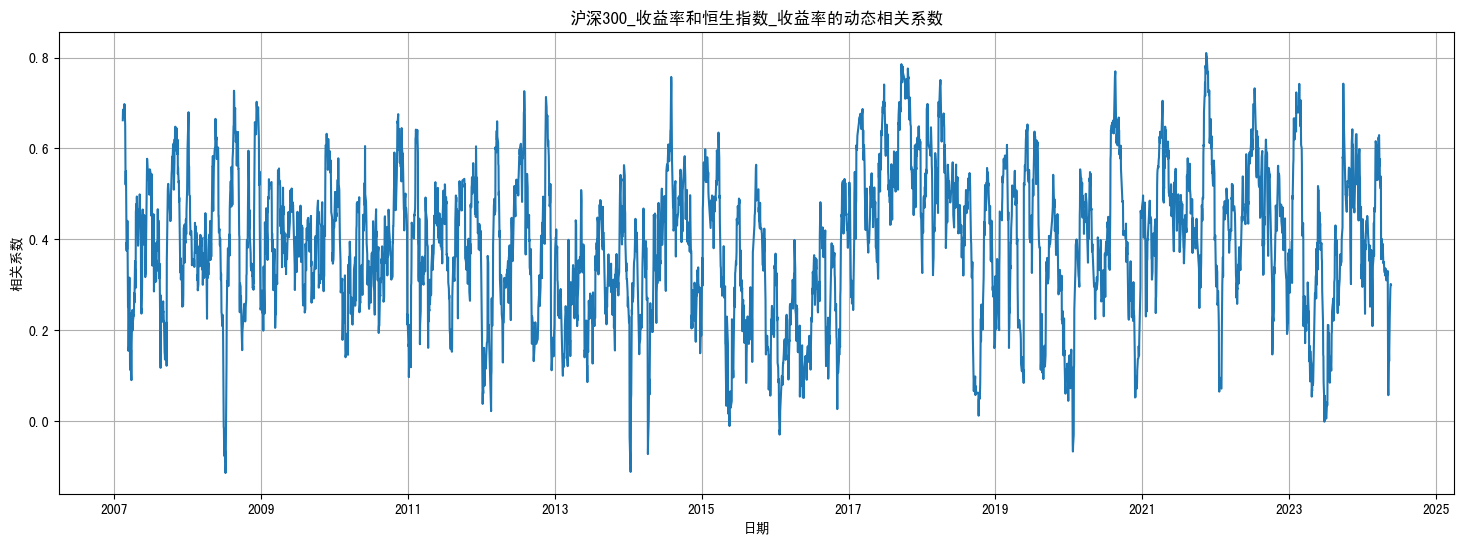

In [16]:
# 绘制资产1和资产2之间的相关系数时序图
plt.figure(figsize=(18, 6))
plt.plot(asset_returns.index[window-1:], corr_series[:, 0, 1])
plt.title(f'{asset_returns.columns[0]}和{asset_returns.columns[1]}的动态相关系数')
plt.xlabel('日期')
plt.ylabel('相关系数')
plt.grid(True)
plt.show()

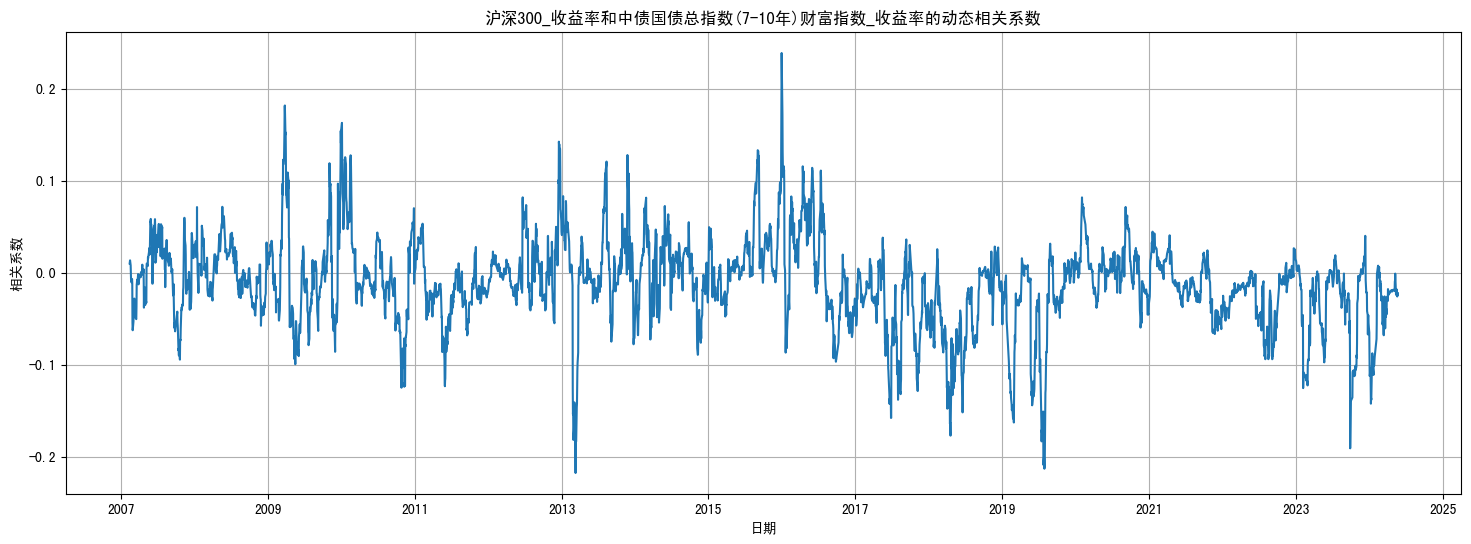

In [17]:
# 绘制资产1和资产3之间的相关系数时序图
plt.figure(figsize=(18, 6))
plt.plot(asset_returns.index[window-1:], corr_series[:, 0, 2])
plt.title(f'{asset_returns.columns[0]}和{asset_returns.columns[2]}的动态相关系数')
plt.xlabel('日期')
plt.ylabel('相关系数')
plt.grid(True)
plt.show()

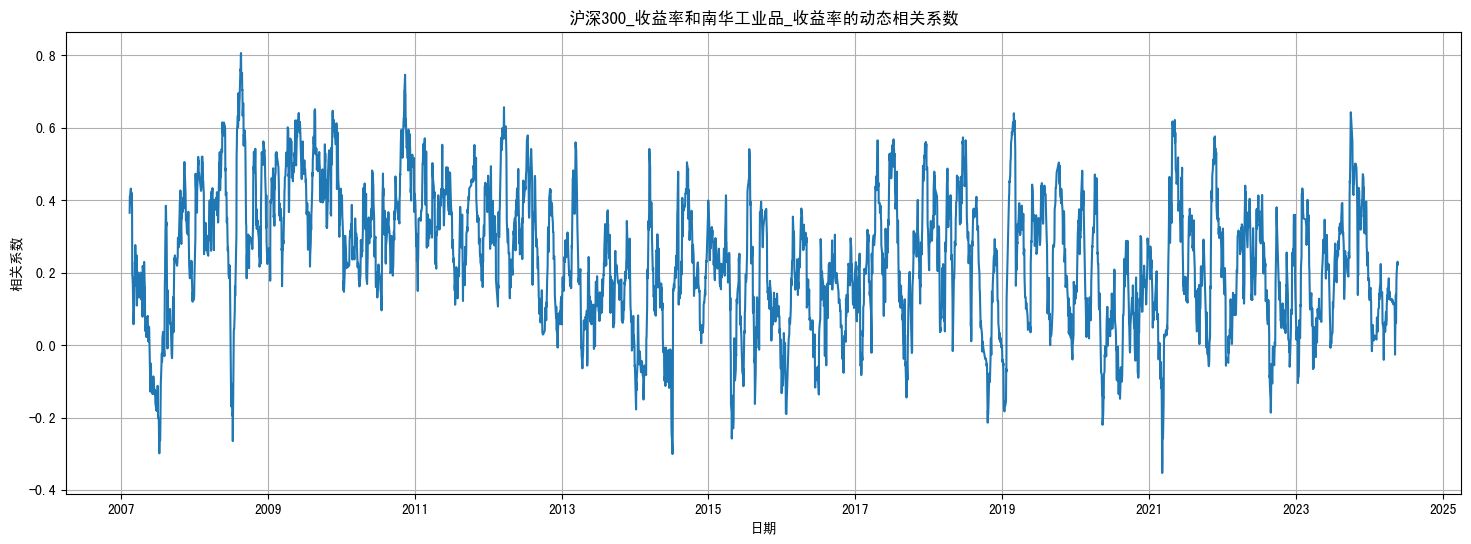

In [18]:
# 绘制资产1和资产4之间的相关系数时序图
plt.figure(figsize=(18, 6))
plt.plot(asset_returns.index[window-1:], corr_series[:, 0, 3])
plt.title(f'{asset_returns.columns[0]}和{asset_returns.columns[3]}的动态相关系数')
plt.xlabel('日期')
plt.ylabel('相关系数')
plt.grid(True)
plt.show()

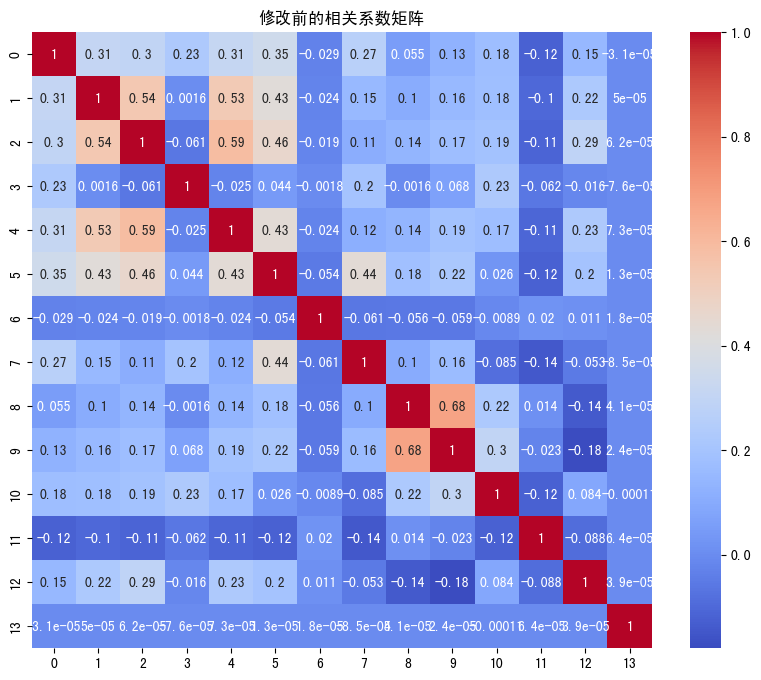

In [19]:
# 绘制相关系数矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_series_X[-1], cmap='coolwarm', annot=True)
plt.title("修改前的相关系数矩阵")
plt.show()

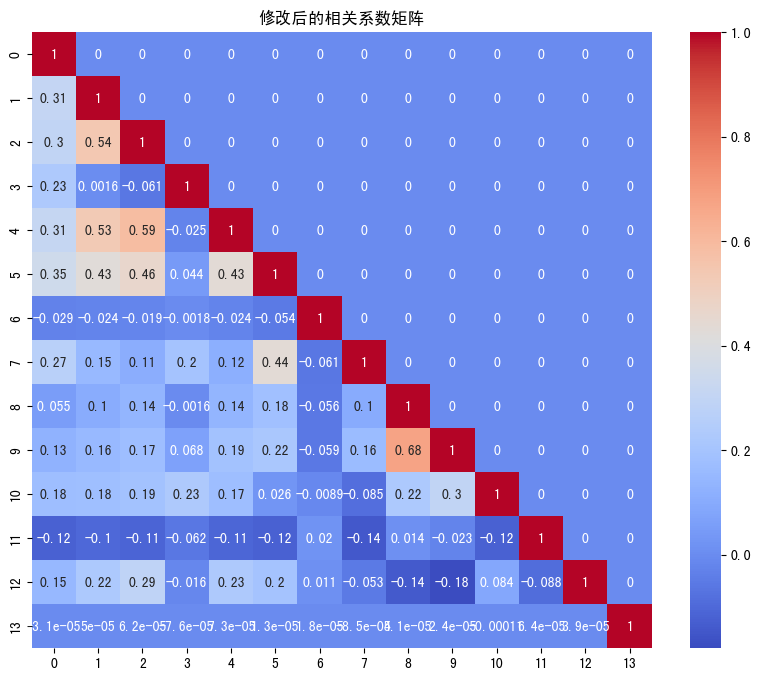

In [20]:
# 将相关系数矩阵的上三角部分设为0
def set_upper_triangle_to_zero(corr_series):
    n_samples, n_assets, _ = corr_series.shape
    for t in range(n_samples):
        # 获取当前时间点的相关系数矩阵
        corr_matrix = corr_series[t]
        # 将上三角部分（不包括对角线）设为0
        mask = np.triu(np.ones_like(corr_matrix), k=1)
        corr_matrix[mask.astype(bool)] = 0
        # 更新相关系数序列
        corr_series[t] = corr_matrix
    return corr_series

# 处理原有的相关系数序列
corr_series_X = set_upper_triangle_to_zero(corr_series_X)

# 验证结果
# 绘制修改后的相关系数矩阵热图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_series_X[-1], cmap='coolwarm', annot=True)
plt.title("修改后的相关系数矩阵")
plt.show()

In [21]:
# 准备相关系数矩阵序列数据
sequences_corr = []
targets_corr = []
days_num = len(corr_series)
time_steps = 20
forecast_horizon = 20  # 预测未来第20期

for i in range(days_num - time_steps - forecast_horizon):
    # 输入序列：20期相关系数矩阵
    sequence = corr_series_X[i:i+time_steps]
    # 目标：提取未来第20期相关系数矩阵的下三角非零元素
    target_matrix = corr_series[i+time_steps+forecast_horizon-1]
    # 获取下三角非零元素（不包括对角线的1）
    target = target_matrix[np.tril_indices_from(target_matrix, k=-1)]
    
    sequences_corr.append(sequence)
    targets_corr.append(target)

# 转换为numpy数组
X_corr = np.array(sequences_corr)
y_corr = np.array(targets_corr)

# 划分训练集和测试集
train_size = int(len(X_corr) * 0.85)
X_corr_train, X_corr_test = X_corr[:train_size], X_corr[train_size:]
y_corr_train, y_corr_test = y_corr[:train_size], y_corr[train_size:]

# 对目标变量进行归一化
scaler = MinMaxScaler()
y_corr_train_scaled = scaler.fit_transform(y_corr_train)
y_corr_test_scaled = scaler.transform(y_corr_test)

# 打印数据形状
print("X_corr shape:", X_corr.shape)  # 应该是 (N, 20, 14, 14)
print("y_corr shape:", y_corr.shape)  # 应该是 (N, 28)
print("训练集大小:", X_corr_train.shape[0])
print("测试集大小:", X_corr_test.shape[0])
print("归一化后y_corr_train范围:", [y_corr_train_scaled.min(), y_corr_train_scaled.max()])

X_corr shape: (4159, 20, 14, 14)
y_corr shape: (4159, 28)
训练集大小: 3535
测试集大小: 624
归一化后y_corr_train范围: [np.float64(0.0), np.float64(1.0000000000000002)]


# 模型架构与训练

## 模型设计思路
1. CNN-LSTM混合架构
   - CNN层用于提取每个时间步内相关系数矩阵的空间特征
   - LSTM层用于捕捉时间序列的长期依赖关系

2. 主要组件
   - 输入层：处理(20, 14, 14)形状的时序相关系数矩阵
   - CNN模块：多层卷积提取空间特征
   - LSTM模块：双层LSTM处理时序特征
   - 全连接层：输出28个相关系数预测值

3. 关键特性
   - BatchNormalization：稳定训练过程
   - Dropout：防止过拟合
   - TimeDistributed：对每个时间步独立应用CNN
   - 分段学习率调整：优化训练效果

## 训练策略
1. 早停机制：patience=20，防止过拟合
2. 学习率调度：分三阶段递减
3. 批量大小：32
4. 验证集比例：20%

In [22]:
# 设置随机种子
keras.utils.set_random_seed(42)

2025-06-08 22:51:56.441289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749394316.463121    8487 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749394316.469863    8487 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749394316.487255    8487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749394316.487283    8487 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749394316.487285    8487 computation_placer.cc:177] computation placer alr

In [23]:
# 设置训练设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [24]:
# 转换为张量并移动到设备
X_train_tensor = torch.FloatTensor(X_corr_train).to(device)
X_test_tensor = torch.FloatTensor(X_corr_test).to(device)
y_train_tensor = torch.FloatTensor(y_corr_train_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_corr_test_scaled).to(device)

In [25]:
input = Input(shape=(X_corr.shape[1], X_corr.shape[2], X_corr.shape[3]))

x = Reshape((X_corr.shape[1], X_corr.shape[2], X_corr.shape[3], -1))(input)
    
# CNN层提取空间特征
# 应用多个CNN层
cnn = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    GlobalAveragePooling2D()
])

# TimeDistributed包装CNN，对每个时间步独立处理
x = TimeDistributed(cnn)(x) 

# LSTM层提取时序特征
x = LSTM(128, return_sequences=True, dropout=0.1, recurrent_dropout=0.3)(x)
x = Dropout(0.2)(x)
x = LSTM(64, dropout=0.1, recurrent_dropout=0.3)(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

# 输出层
# 全连接层输出下三角元素
outputs = Dense(28, activation='relu')(x)

# 创建模型
model = keras.Model(inputs=input, outputs=outputs)

# 编译模型
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=['mae']
)

# 将模型移至GPU（如果可用）
model.to(device)

<Functional name=functional_1, built=True>

In [26]:
# 设置早停策略
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

def piecewise_schedule(epoch):
    if epoch < 5:  
        return 0.0005
    elif epoch < 15:
        return 0.0001
    else:             
        return 0.00001

scheduler = LearningRateScheduler(piecewise_schedule)

# 训练模型
history = model.fit(
    X_train_tensor,
    y_train_tensor,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, scheduler],
    verbose=1
)

Epoch 1/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - loss: 0.1691 - mae: 0.3580 - val_loss: 0.0201 - val_mae: 0.1075 - learning_rate: 5.0000e-04
Epoch 2/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 265ms/step - loss: 0.0416 - mae: 0.1609 - val_loss: 0.0170 - val_mae: 0.1000 - learning_rate: 5.0000e-04
Epoch 3/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 264ms/step - loss: 0.0317 - mae: 0.1404 - val_loss: 0.0171 - val_mae: 0.0996 - learning_rate: 5.0000e-04
Epoch 4/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - loss: 0.0283 - mae: 0.1323 - val_loss: 0.0168 - val_mae: 0.0980 - learning_rate: 5.0000e-04
Epoch 5/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - loss: 0.0262 - mae: 0.1275 - val_loss: 0.0169 - val_mae: 0.0974 - learning_rate: 5.0000e-04
Epoch 6/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - loss: 0.0248 - mae: 0.1236 - val_loss: 0.0168 - val_mae: 0.0972 - learning_rate: 1.0000e-04
Epoch 7/150
89/89 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step - loss: 0.0244 - mae: 0.1222 - val_loss: 0.0167 - val_mae:

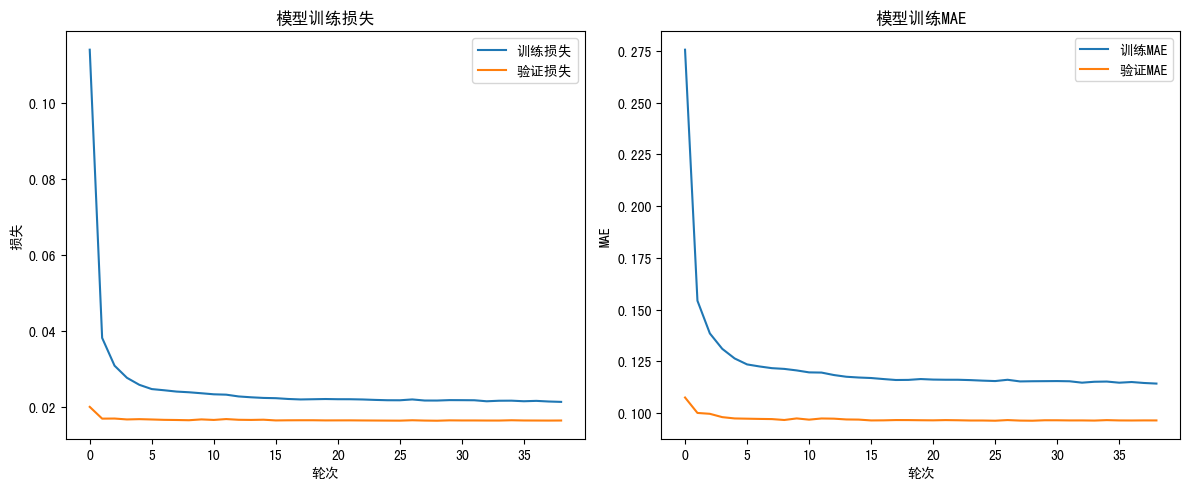

最佳验证损失: 0.016478


In [27]:
# 绘制训练过程
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='训练损失')
plt.plot(history.history['val_loss'], label='验证损失')
plt.title('模型训练损失')
plt.xlabel('轮次')
plt.ylabel('损失')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='训练MAE')
plt.plot(history.history['val_mae'], label='验证MAE')
plt.title('模型训练MAE')
plt.xlabel('轮次')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# 打印最佳验证损失
best_val_loss = min(history.history['val_loss'])
print(f"最佳验证损失: {best_val_loss:.6f}")

## 模型评估指标说明

1. MSE (均方误差)
   - 衡量预测值与实际值差异的平方平均
   - 对较大误差更敏感
   
2. MAE (平均绝对误差)
   - 预测值与实际值绝对差异的平均
   - 提供直观的误差大小度量
   
3. R² (决定系数)
   - 反映模型解释数据变异的程度
   - 值越接近1表示预测效果越好

In [28]:
# 获取测试集预测结果
y_pred = model.predict(X_test_tensor)

# 计算每个相关系数的评估指标
mse_per_coef = mean_squared_error(y_corr_test_scaled, y_pred, multioutput='raw_values')
mae_per_coef = mean_absolute_error(y_corr_test_scaled, y_pred, multioutput='raw_values')
r2_per_coef = r2_score(y_corr_test_scaled, y_pred, multioutput='raw_values')

# 获取资产名称
asset_names = asset_returns.columns

# 创建下三角索引的资产对列表
pairs = []
n = len(asset_names)
for i in range(n):
    for j in range(i):
        pairs.append(f"{asset_names[i]}-{asset_names[j]}")

# 创建评估指标DataFrame
metrics_df = pd.DataFrame({
    '资产对': pairs,
    'MSE': mse_per_coef,
    'MAE': mae_per_coef,
    'R2': r2_per_coef
})

# 显示评估指标
print("\n每个相关系数的预测效果评估:")
metrics_df

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step

每个相关系数的预测效果评估:


,资产对,MSE,MAE,R2
0,恒生指数_收益率-沪深300_收益率,0.040127,0.164651,-0.161740
1,中债国债总指数(7-10年)财富指数_收益率-沪深300_收益率,0.008000,0.064292,-0.374414
2,中债国债总指数(7-10年)财富指数_收益率-恒生指数_收益率,0.007974,0.067953,-0.133583
3,南华工业品_收益率-沪深300_收益率,0.017575,0.110112,-0.032173
4,南华工业品_收益率-恒生指数_收益率,0.026752,0.125498,-0.068643
5,南华工业品_收益率-中债国债总指数(7-10年)财富指数_收益率,0.005173,0.057313,-0.075540
6,纳斯达克100_收益率-沪深300_收益率,0.019866,0.108524,-0.022627
7,纳斯达克100_收益率-恒生指数_收益率,0.034063,0.144272,-0.057858
8,纳斯达克100_收益率-中债国债总指数(7-10年)财富指数_收益率,0.004378,0.051334,-0.087109
9,纳斯达克100_收益率-南华工业品_收益率,0.018861,0.106075,0.053992


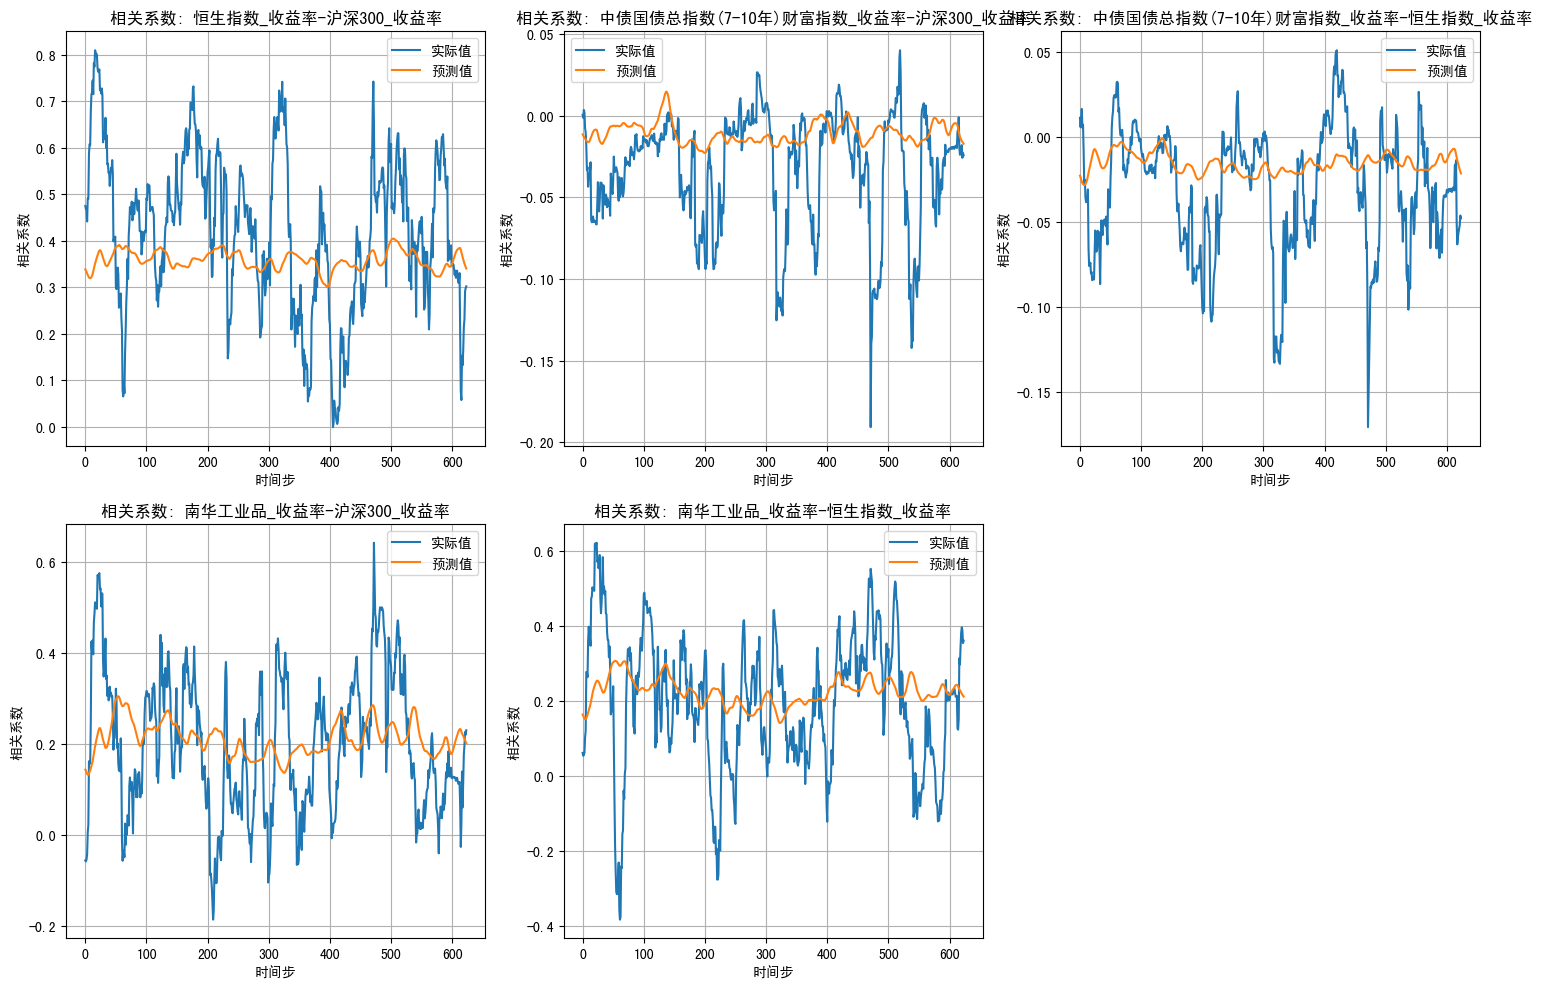


反归一化后每个相关系数的预测效果评估:


,资产对,MSE,MAE,R2
0,恒生指数_收益率-沪深300_收益率,0.032445,0.148053,-0.161740
1,中债国债总指数(7-10年)财富指数_收益率-沪深300_收益率,0.001665,0.029328,-0.374414
2,中债国债总指数(7-10年)财富指数_收益率-恒生指数_收益率,0.001470,0.029173,-0.133583
3,南华工业品_收益率-沪深300_收益率,0.023634,0.127687,-0.032173
4,南华工业品_收益率-恒生指数_收益率,0.034540,0.142600,-0.068643
5,南华工业品_收益率-中债国债总指数(7-10年)财富指数_收益率,0.000795,0.022467,-0.075540
6,纳斯达克100_收益率-沪深300_收益率,0.028423,0.129808,-0.022627
7,纳斯达克100_收益率-恒生指数_收益率,0.031544,0.138834,-0.057858
8,纳斯达克100_收益率-中债国债总指数(7-10年)财富指数_收益率,0.000723,0.020856,-0.087109
9,纳斯达克100_收益率-南华工业品_收益率,0.022990,0.117112,0.053992


In [29]:
# 反归一化预测值
y_pred_inverse = scaler.inverse_transform(y_pred)

# 可视化前5个相关系数的预测效果
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 3, i+1)
    plt.plot(y_corr_test[:, i], label='实际值')
    plt.plot(y_pred_inverse[:, i], label='预测值')
    plt.title(f'相关系数: {pairs[i]}')
    plt.xlabel('时间步')
    plt.ylabel('相关系数')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# 计算反归一化后的评估指标
mse_per_coef = mean_squared_error(y_corr_test, y_pred_inverse, multioutput='raw_values')
mae_per_coef = mean_absolute_error(y_corr_test, y_pred_inverse, multioutput='raw_values')
r2_per_coef = r2_score(y_corr_test, y_pred_inverse, multioutput='raw_values')

# 更新评估指标DataFrame
metrics_df = pd.DataFrame({
    '资产对': pairs,
    'MSE': mse_per_coef,
    'MAE': mae_per_coef,
    'R2': r2_per_coef
})

print("\n反归一化后每个相关系数的预测效果评估:")
metrics_df

In [30]:
metrics_df['R2'].mean()

np.float64(-0.1098264822909089)

In [31]:
def reconstruct_correlation_matrix(target):
    # 计算原始矩阵的维度
    n = 8
    
    # 创建一个全零矩阵
    matrix = np.zeros((n, n))
    
    # 获取下三角部分（不包含对角线）的索引
    tril_indices = np.tril_indices(n, k=-1)
    
    # 将目标元素填充到下三角部分
    matrix[tril_indices] = target
    
    # 复制下三角部分到上三角部分（转置）
    matrix = matrix + matrix.T
    
    # 在对角线上填充1
    np.fill_diagonal(matrix, 1)
    
    return matrix

In [32]:
y_pred_inverse.shape

(624, 28)

In [36]:
pred_corr_df = pd.DataFrame(y_pred_inverse, index=log_returns.index[-len(y_corr_test):], columns=pairs)
pred_corr_df

,恒生指数_收益率-沪深300_收益率,中债国债总指数(7-10年)财富指数_收益率-沪深300_收益率,中债国债总指数(7-10年)财富指数_收益率-恒生指数_收益率,南华工业品_收益率-沪深300_收益率,南华工业品_收益率-恒生指数_收益率,南华工业品_收益率-中债国债总指数(7-10年)财富指数_收益率,纳斯达克100_收益率-沪深300_收益率,纳斯达克100_收益率-恒生指数_收益率,纳斯达克100_收益率-中债国债总指数(7-10年)财富指数_收益率,纳斯达克100_收益率-南华工业品_收益率,...,十年美债_收益率-南华工业品_收益率,十年美债_收益率-纳斯达克100_收益率,十年美债_收益率-布油_收益率,沪金_收益率-沪深300_收益率,沪金_收益率-恒生指数_收益率,沪金_收益率-中债国债总指数(7-10年)财富指数_收益率,沪金_收益率-南华工业品_收益率,沪金_收益率-纳斯达克100_收益率,沪金_收益率-布油_收益率,沪金_收益率-十年美债_收益率
2022-10-25,0.338671,-0.011504,-0.022877,0.143933,0.164138,-0.022211,0.083370,0.106183,-0.024674,0.007820,...,-0.042155,-0.086671,-0.062656,-0.051840,-0.050574,-0.005454,0.022116,-0.028187,-0.029262,-0.002383
2022-10-26,0.336114,-0.012269,-0.023879,0.141609,0.160974,-0.023106,0.082157,0.104804,-0.025429,0.007834,...,-0.042642,-0.087444,-0.063410,-0.053723,-0.053123,-0.005813,0.018227,-0.029401,-0.030678,-0.002842
2022-10-27,0.333183,-0.012999,-0.025087,0.138103,0.157058,-0.024111,0.080507,0.102655,-0.026273,0.007103,...,-0.043279,-0.088211,-0.064102,-0.055617,-0.056231,-0.006342,0.013877,-0.031280,-0.032593,-0.003321
2022-10-28,0.329699,-0.013689,-0.026322,0.134600,0.153459,-0.025157,0.078312,0.099665,-0.027016,0.006018,...,-0.043866,-0.088972,-0.064668,-0.056804,-0.059229,-0.006850,0.009904,-0.033129,-0.034527,-0.003781
2022-10-31,0.326615,-0.014087,-0.027244,0.132548,0.151827,-0.025824,0.075834,0.096871,-0.027032,0.005273,...,-0.043948,-0.089248,-0.064294,-0.055973,-0.060809,-0.007087,0.007677,-0.033972,-0.035678,-0.003873
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-16,0.355326,-0.014827,-0.016655,0.214947,0.222628,-0.020673,0.077817,0.120891,-0.013997,0.035682,...,-0.036379,-0.100278,-0.069886,-0.017555,-0.003983,0.000180,0.077762,-0.001123,-0.002968,-0.006536
2025-05-19,0.351035,-0.015510,-0.018036,0.211353,0.219574,-0.021800,0.076040,0.117842,-0.014765,0.036005,...,-0.036992,-0.101366,-0.071847,-0.017264,-0.006124,-0.000484,0.072625,-0.001993,-0.005251,-0.006802
2025-05-20,0.347143,-0.016127,-0.019310,0.207957,0.216775,-0.022806,0.074434,0.115095,-0.015443,0.036115,...,-0.037562,-0.102387,-0.073523,-0.017140,-0.008253,-0.001136,0.067851,-0.002801,-0.007371,-0.007058
2025-05-21,0.343632,-0.016690,-0.020464,0.205023,0.214392,-0.023697,0.072983,0.112645,-0.016030,0.036138,...,-0.038056,-0.103397,-0.075038,-0.016927,-0.010100,-0.001762,0.063553,-0.003492,-0.009287,-0.007315


In [37]:
pred_corr_df.to_csv('资产相关性预测结果.csv', encoding='utf-8-sig')